# Mediation Analysis: Gavi Status, Delivery/Dosing, and HPV Coverage

Does Gavi funding status affect HPV vaccine coverage through delivery strategy or dosing schedule?

| Variable | Role | Type | Values |
|----------|------|------|---------|
| Gavi Status | Independent (X) | Binary | 0=Non-Gavi, 1=Gavi |
| Delivery Strategy | Mediator (M1) | Categorical | School-based, Facility-based, Mixed, Varies |
| Dosing Schedule | Mediator (M2) | Categorical | 1 dose, 2 doses (6mo), 2 doses (12mo) |
| HPV1 Coverage | Dependent (Y) | Continuous | 0-1 |

## Analysis Structure

### Part 1: Traditional Tests 
- **Path A**: Chi-square test (X → M association)
- **Path B**: One-way ANOVA (M → Y differences)
- **Path C**: Independent t-test (X → Y total effect)

### Part 2: Regression-Based Mediation (Pingouin)
- **Path a**: Linear regression (X → M)
- **Path b**: Linear regression (M → Y | X)
- **Path c'**: Direct effect (X → Y | M)
- **Indirect effect**: Bootstrap CI for a × b

### Part 3: Visualization

In [19]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

---
## 1. Data Preparation

In [ ]:
# Load data
dosing_df = pd.read_csv('../dat/Socio_Econ/raw/current_dosing.csv')
delivery_df = pd.read_csv('../dat/Socio_Econ/raw/delivery_strategy.csv')

# Merge
df = delivery_df.merge(
    dosing_df[['ISO', 'Gavi Status']],
    left_on='ISO_3_CODE', right_on='ISO', how='inner'
).drop('ISO', axis=1)

# Filter complete cases
df_analysis = df[
    df['HPV1_COVERAGELASTYEAR'].notna() &
    df['HPV_PRIM_DELIV_STRATEGY'].notna() &
    df['HPV_INT_DOSES'].notna() &
    df['Gavi Status'].notna()
].copy()

# Encode variables
df_analysis['X'] = (df_analysis['Gavi Status'] == 'Gavi').astype(int)
df_analysis['Y'] = df_analysis['HPV1_COVERAGELASTYEAR']

# Numeric encoding for mediators
delivery_map = {'School-based': 0, 'Facility-based': 1, 'mixed': 2, 'Varies by region/province': 3}
dose_map = {'1 dose': 1, '2 doses (6 months)': 2, '2 doses (12 months)': 3}
df_analysis['M1'] = df_analysis['HPV_PRIM_DELIV_STRATEGY'].map(delivery_map)
df_analysis['M2'] = df_analysis['HPV_INT_DOSES'].map(dose_map)

print(f"N = {len(df_analysis)} countries with complete data")
print(f"Gavi: {df_analysis['X'].sum()}, Non-Gavi: {(df_analysis['X']==0).sum()}")

---
# PART 1: Traditional Statistical Tests
---

In [21]:
def calculate_model_stats(df, mediator_var):
    """
    Calculate all statistics for a mediation model
    Returns a dictionary with all statistics needed for plotting
    """
    results = {}
    
    # PATH A: Chi-square test (Gavi Status → Mediator)
    contingency = pd.crosstab(df['X'], df[mediator_var])
    chi2, p_a, dof, expected = stats.chi2_contingency(contingency)
    results['a_stat'] = chi2
    results['a_p'] = p_a
    
    # PATH B: ANOVA (Mediator → Coverage)
    mediator_values = df[mediator_var].dropna().unique()
    groups = [df[df[mediator_var]==val]['Y'].values for val in mediator_values]
    f_stat, p_b = stats.f_oneway(*groups)
    results['b_stat'] = f_stat
    results['b_p'] = p_b
    
    # PATH C: t-test (Gavi Status → Coverage)
    gavi = df[df['X']==1]['Y']
    non_gavi = df[df['X']==0]['Y']
    t_stat, p_c = stats.ttest_ind(gavi, non_gavi)
    results['t_stat'] = t_stat
    results['c_p'] = p_c
    
    # Sample sizes
    results['n_gavi'] = len(gavi)
    results['n_non_gavi'] = len(non_gavi)
    results['n_total'] = len(df)
    
    # Additional descriptive statistics
    results['gavi_mean'] = gavi.mean()
    results['non_gavi_mean'] = non_gavi.mean()
    results['mean_diff'] = gavi.mean() - non_gavi.mean()
    
    # Means by mediator categories
    mediator_means = df.groupby(mediator_var)['Y'].agg(['mean', 'count', 'std']).round(3)
    results['mediator_means'] = mediator_means
    
    return results

def draw_mediation(ax, mediator, stats_dict):
    """
    Draw mediation diagram using statistics from dictionary
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Node positions
    X, M, Y = (1.5, 3), (5, 6.5), (8.5, 3)
    
    # Draw nodes
    for pos, label, color in [(X, 'Gavi Status', '#E8F4FD'), 
                              (M, mediator, '#FFF9E6'), 
                              (Y, 'HPV Coverage', '#E8F8E8')]:
        ax.add_patch(plt.Rectangle((pos[0]-1.2, pos[1]-0.6), 2.4, 1.2, 
                     facecolor=color, edgecolor='#333', linewidth=1.5, zorder=2))
        ax.text(pos[0], pos[1], label, ha='center', va='center', 
                fontsize=11, fontweight='bold', zorder=3)
    
    # Formatting function
    def fmt(stat_val, p, stat_type='chi2'):
        color = '#2E7D32' if p < 0.05 else '#757575'
        weight = 'bold' if p < 0.05 else 'normal'
        lw = 2 if p < 0.05 else 1
        
        if stat_type == 'chi2':
            label = f'χ² = {stat_val:.2f}'
        elif stat_type == 'F':
            label = f'F = {stat_val:.2f}'
        else:  # t-test
            label = f't = {stat_val:.2f}'
        
        return label, color, weight, lw
    
    # Draw path a: X → M (Chi-square)
    a_txt, a_col, a_wt, a_lw = fmt(stats_dict['a_stat'], stats_dict['a_p'], 'chi2')
    ax.annotate('', xy=(M[0]-1, M[1]-0.6), xytext=(X[0]+0.8, X[1]+0.6),
                arrowprops=dict(arrowstyle='-|>', color=a_col, lw=a_lw))
    ax.text(3.0, 5.9, f'Path a\n{a_txt}\np = {stats_dict["a_p"]:.3f}', 
            fontsize=10, color=a_col, fontweight=a_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path b: M → Y (ANOVA)
    b_txt, b_col, b_wt, b_lw = fmt(stats_dict['b_stat'], stats_dict['b_p'], 'F')
    ax.annotate('', xy=(Y[0]-0.8, Y[1]+0.6), xytext=(M[0]+1, M[1]-0.6),
                arrowprops=dict(arrowstyle='-|>', color=b_col, lw=b_lw))
    ax.text(7.0, 5.9, f'Path b\n{b_txt}\np = {stats_dict["b_p"]:.3f}', 
            fontsize=10, color=b_col, fontweight=b_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path c': X → Y (t-test)
    c_txt, c_col, c_wt, c_lw = fmt(stats_dict['t_stat'], stats_dict['c_p'], 't')
    ax.annotate('', xy=(Y[0]-1.2, Y[1]), xytext=(X[0]+1.2, X[1]),
                arrowprops=dict(arrowstyle='-|>', color=c_col, lw=c_lw, linestyle='--'))
    ax.text(5, 2.2, f"Path c'\n{c_txt}\np = {stats_dict['c_p']:.3f}", 
            fontsize=10, color=c_col, fontweight=c_wt, ha='center', va='center', 
            linespacing=1.3, bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='none', alpha=0.8))

MODEL STATISTICS SUMMARY

Model 1: Delivery Strategy
----------------------------------------
Path a (χ²): 8.2548, p = 0.0410
Path b (F): 1.9465, p = 0.1255
Path c (t): 0.8995, p = 0.3701
Gavi mean: 0.670, Non-Gavi mean: 0.614
Mean difference: 0.056

Means by Delivery Strategy:
                            mean  count    std
HPV_PRIM_DELIV_STRATEGY                       
Facility-based             0.520     29  0.296
School-based               0.660     80  0.258
Varies by region/province  0.605      2  0.078
mixed                      0.631     18  0.264


Model 2: Dosing Schedule
----------------------------------------
Path a (χ²): 21.1421, p = 0.0000
Path b (F): 0.2912, p = 0.7478
Path c (t): 0.8995, p = 0.3701
Gavi mean: 0.670, Non-Gavi mean: 0.614
Mean difference: 0.056

Means by Dosing Schedule:
                      mean  count    std
HPV_INT_DOSES                           
1 dose               0.641     66  0.263
2 doses (12 months)  0.650      2  0.212
2 doses (6 months)   0.

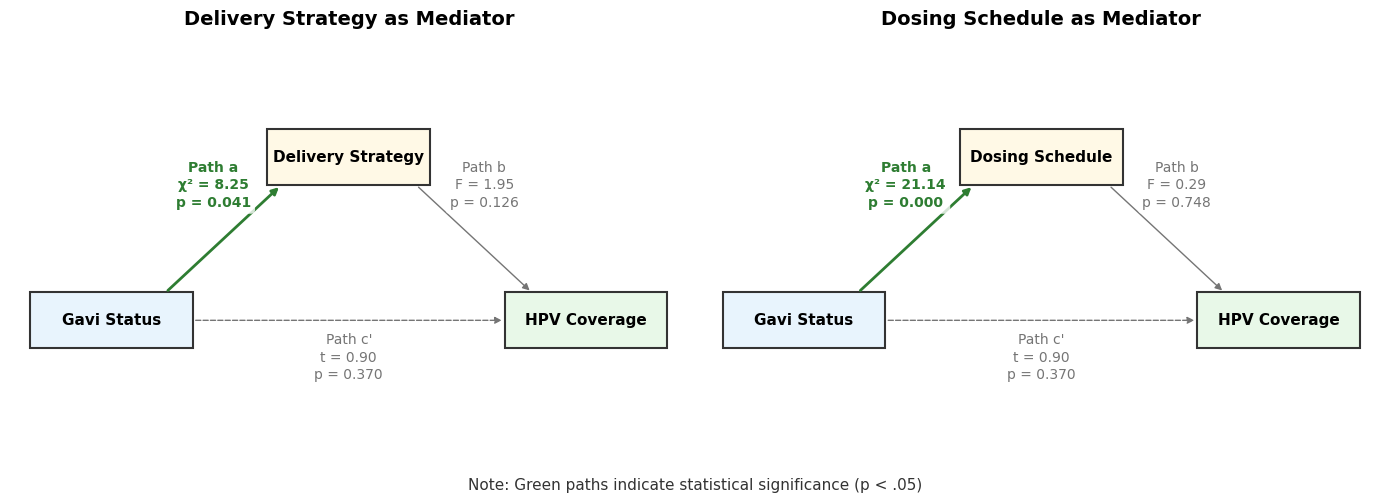

In [22]:
# Main execution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate statistics for both models
delivery_stats = calculate_model_stats(df_analysis, 'HPV_PRIM_DELIV_STRATEGY')
dosing_stats = calculate_model_stats(df_analysis, 'HPV_INT_DOSES')

# Print summary of statistics
print("="*70)
print("MODEL STATISTICS SUMMARY")
print("="*70)

print("\nModel 1: Delivery Strategy")
print("-"*40)
print(f"Path a (χ²): {delivery_stats['a_stat']:.4f}, p = {delivery_stats['a_p']:.4f}")
print(f"Path b (F): {delivery_stats['b_stat']:.4f}, p = {delivery_stats['b_p']:.4f}")
print(f"Path c (t): {delivery_stats['t_stat']:.4f}, p = {delivery_stats['c_p']:.4f}")
print(f"Gavi mean: {delivery_stats['gavi_mean']:.3f}, Non-Gavi mean: {delivery_stats['non_gavi_mean']:.3f}")
print(f"Mean difference: {delivery_stats['mean_diff']:.3f}")
print("\nMeans by Delivery Strategy:")
print(delivery_stats['mediator_means'])

print("\n" + "="*70)
print("\nModel 2: Dosing Schedule")
print("-"*40)
print(f"Path a (χ²): {dosing_stats['a_stat']:.4f}, p = {dosing_stats['a_p']:.4f}")
print(f"Path b (F): {dosing_stats['b_stat']:.4f}, p = {dosing_stats['b_p']:.4f}")
print(f"Path c (t): {dosing_stats['t_stat']:.4f}, p = {dosing_stats['c_p']:.4f}")
print(f"Gavi mean: {dosing_stats['gavi_mean']:.3f}, Non-Gavi mean: {dosing_stats['non_gavi_mean']:.3f}")
print(f"Mean difference: {dosing_stats['mean_diff']:.3f}")
print("\nMeans by Dosing Schedule:")
print(dosing_stats['mediator_means'])

# Draw the plots
draw_mediation(axes[0], 'Delivery Strategy', delivery_stats)
axes[0].set_title('Delivery Strategy as Mediator', fontsize=14, fontweight='bold', pad=45)

draw_mediation(axes[1], 'Dosing Schedule', dosing_stats)
axes[1].set_title('Dosing Schedule as Mediator', fontsize=14, fontweight='bold', pad=45)

# Add note
fig.text(0.5, 0.01, 
         'Note: Green paths indicate statistical significance (p < .05)',
         ha='center', fontsize=11, color='#333')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

---
# PART 2: Regression-Based Mediation (Pingouin)
---

## 2.1 Model 1: Delivery Strategy Mediation

In [23]:
print("="*70)
print("REGRESSION: Gavi → Delivery Strategy → Coverage")
print("="*70)

# Path A: X → M1
print("\nPath A (X → M):")
path_a1_reg = pg.linear_regression(df_analysis[['X']], df_analysis['M1'])
display(path_a1_reg)

# Path B + C': X + M1 → Y
print("\nPath B + C' (X + M → Y):")
path_bc1_reg = pg.linear_regression(df_analysis[['X', 'M1']], df_analysis['Y'])
display(path_bc1_reg)

REGRESSION: Gavi → Delivery Strategy → Coverage

Path A (X → M):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.518868,0.076766,6.759085,4.516967e-10,0.00739,-0.000426,0.366962,0.670774
1,X,0.176784,0.181803,0.972397,3.327014e-01,0.00739,-0.000426,-0.182970,0.536539



Path B + C' (X + M → Y):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.633467,0.030521,20.755164,1.782589e-42,0.018704,0.003128,0.573067,0.693867
1,X,0.062628,0.062218,1.006592,3.160598e-01,0.018704,0.003128,-0.060499,0.185755
2,M1,-0.038136,0.030255,-1.260476,2.098271e-01,0.018704,0.003128,-0.098010,0.021738


In [24]:
# Full mediation with bootstrap
print("Full Mediation Analysis (5000 bootstrap):")
med1 = pg.mediation_analysis(data=df_analysis, x='X', m='M1', y='Y', n_boot=5000, seed=42)
display(med1)

Full Mediation Analysis (5000 bootstrap):


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,M1 ~ X,0.176784,0.181803,0.332701,-0.182970,0.536539,No
1,Y ~ M1,-0.035518,0.030145,0.240903,-0.095169,0.024133,No
2,Total,0.055886,0.062131,0.370095,-0.067060,0.178832,No
3,Direct,0.062628,0.062218,0.316060,-0.060499,0.185755,No
4,Indirect,-0.006742,0.011481,0.492400,-0.046169,0.005597,No


## 2.2 Model 2: Dosing Schedule Mediation

In [25]:
print("="*70)
print("REGRESSION: Gavi → Dosing Schedule → Coverage")
print("="*70)

# Path A: X → M2
print("\nPath A (X → M):")
path_a2_reg = pg.linear_regression(df_analysis[['X']], df_analysis['M2'])
display(path_a2_reg)

# Path B + C': X + M2 → Y
print("\nPath B + C' (X + M → Y):")
path_bc2_reg = pg.linear_regression(df_analysis[['X', 'M2']], df_analysis['Y'])
display(path_bc2_reg)

REGRESSION: Gavi → Dosing Schedule → Coverage

Path A (X → M):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.584906,0.049017,32.333870,3.775989e-63,0.107689,0.100663,1.487910,1.681901
1,X,-0.454471,0.116085,-3.914979,1.466973e-04,0.107689,0.100663,-0.684182,-0.224759



Path B + C' (X + M → Y):


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.642433,0.079982,8.032191,5.851668e-13,0.007472,-0.008282,0.484151,0.800716
1,X,0.047641,0.065996,0.721876,4.717083e-01,0.007472,-0.008282,-0.082963,0.178244
2,M2,-0.018142,0.047654,-0.380715,7.040559e-01,0.007472,-0.008282,-0.112448,0.076163


In [26]:
# Full mediation with bootstrap
print("Full Mediation Analysis (5000 bootstrap):")
med2 = pg.mediation_analysis(data=df_analysis, x='X', m='M2', y='Y', n_boot=5000, seed=42)
display(med2)

Full Mediation Analysis (5000 bootstrap):


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,M2 ~ X,-0.454471,0.116085,0.000147,-0.684182,-0.224759,Yes
1,Y ~ M2,-0.029431,0.044930,0.513621,-0.118339,0.059477,No
2,Total,0.055886,0.062131,0.370095,-0.067060,0.178832,No
3,Direct,0.047641,0.065996,0.471708,-0.082963,0.178244,No
4,Indirect,0.008245,0.021892,0.673600,-0.031629,0.059142,No


In [27]:
# Extract data from mediation results
mediation_data = {
    'Delivery': {
        'a_coef': med1[med1['path'].str.contains('M1 ~')]['coef'].values[0],
        'a_p': med1[med1['path'].str.contains('M1 ~')]['pval'].values[0],
        'b_coef': med1[med1['path'].str.contains('Y ~')]['coef'].values[0],
        'b_p': med1[med1['path'].str.contains('Y ~')]['pval'].values[0],
        'c_coef': med1[med1['path']=='Direct']['coef'].values[0],
        'c_p': med1[med1['path']=='Direct']['pval'].values[0],
        'indirect': med1[med1['path']=='Indirect']['coef'].values[0],
        'indirect_p': med1[med1['path']=='Indirect']['pval'].values[0]
    },
    'Dosing': {
        'a_coef': med2[med2['path'].str.contains('M2 ~')]['coef'].values[0],
        'a_p': med2[med2['path'].str.contains('M2 ~')]['pval'].values[0],
        'b_coef': med2[med2['path'].str.contains('Y ~')]['coef'].values[0],
        'b_p': med2[med2['path'].str.contains('Y ~')]['pval'].values[0],
        'c_coef': med2[med2['path']=='Direct']['coef'].values[0],
        'c_p': med2[med2['path']=='Direct']['pval'].values[0],
        'indirect': med2[med2['path']=='Indirect']['coef'].values[0],
        'indirect_p': med2[med2['path']=='Indirect']['pval'].values[0]
    }
}

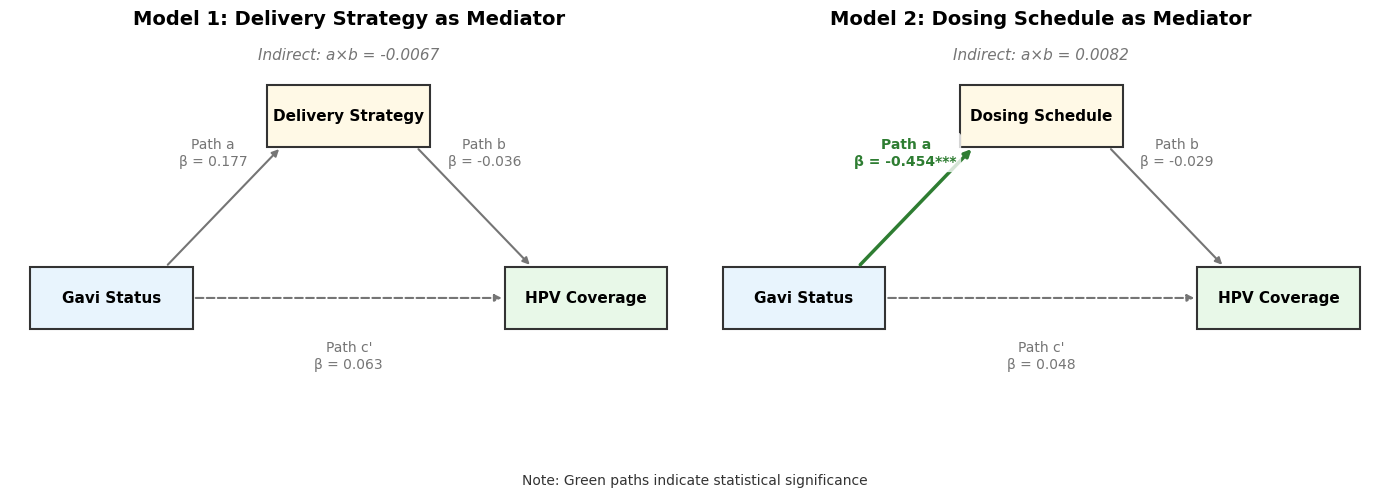

In [28]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

def fmt(coef, p):
    """Format coefficient with significance stars"""
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    color = '#2E7D32' if p < 0.05 else '#757575'
    weight = 'bold' if p < 0.05 else 'normal'
    lw = 2.5 if p < 0.05 else 1.5
    return f'β = {coef:.3f}{sig}', color, weight, lw

def draw_mediation_beta(ax, mediator, data):
    """Draw a single mediation diagram with beta coefficients"""
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Node positions
    X, M, Y = (1.5, 3), (5, 6.5), (8.5, 3)
    
    # Draw nodes
    for pos, label, color in [(X, 'Gavi Status', '#E8F4FD'), 
                              (M, mediator, '#FFF9E6'), 
                              (Y, 'HPV Coverage', '#E8F8E8')]:
        ax.add_patch(plt.Rectangle((pos[0]-1.2, pos[1]-0.6), 2.4, 1.2,
                     facecolor=color, edgecolor='#333', linewidth=1.5, zorder=2))
        ax.text(pos[0], pos[1], label, ha='center', va='center',
                fontsize=11, fontweight='bold', zorder=3)
    
    # Draw path a: X → M
    a_txt, a_col, a_wt, a_lw = fmt(data['a_coef'], data['a_p'])
    ax.annotate('', xy=(M[0]-1, M[1]-0.6), xytext=(X[0]+0.8, X[1]+0.6),
                arrowprops=dict(arrowstyle='-|>', color=a_col, lw=a_lw))
    ax.text(3.0, 5.8, f'Path a\n{a_txt}', fontsize=10, color=a_col,
            fontweight=a_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path b: M → Y
    b_txt, b_col, b_wt, b_lw = fmt(data['b_coef'], data['b_p'])
    ax.annotate('', xy=(Y[0]-0.8, Y[1]+0.6), xytext=(M[0]+1, M[1]-0.6),
                arrowprops=dict(arrowstyle='-|>', color=b_col, lw=b_lw))
    ax.text(7.0, 5.8, f'Path b\n{b_txt}', fontsize=10, color=b_col,
            fontweight=b_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Draw path c': X → Y (direct)
    c_txt, c_col, c_wt, c_lw = fmt(data['c_coef'], data['c_p'])
    ax.annotate('', xy=(Y[0]-1.2, Y[1]), xytext=(X[0]+1.2, X[1]),
                arrowprops=dict(arrowstyle='-|>', color=c_col, lw=c_lw, linestyle='--'))
    ax.text(5, 1.9, f"Path c'\n{c_txt}", fontsize=10, color=c_col,
            fontweight=c_wt, ha='center', va='center', linespacing=1.3,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Add indirect effect
    sig_ind = '***' if data['indirect_p'] < 0.001 else '**' if data['indirect_p'] < 0.01 else '*' if data['indirect_p'] < 0.05 else ''
    color_ind = '#2E7D32' if data['indirect_p'] < 0.05 else '#757575'
    ax.text(5, 7.6, f"Indirect: a×b = {data['indirect']:.4f}{sig_ind}",
            ha='center', fontsize=11, color=color_ind, style='italic',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))

# Draw both models
draw_mediation_beta(axes[0], 'Delivery Strategy', mediation_data['Delivery'])
axes[0].set_title('Model 1: Delivery Strategy as Mediator', fontsize=14, fontweight='bold', pad=10)

draw_mediation_beta(axes[1], 'Dosing Schedule', mediation_data['Dosing'])
axes[1].set_title('Model 2: Dosing Schedule as Mediator', fontsize=14, fontweight='bold', pad=10)

fig.text(0.5, 0.02,
         'Note: Green paths indicate statistical significance',
         ha='center', fontsize=10, color='#333')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()